In [1]:
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import cv2
import os
import numpy as np
import time
import argparse
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [4]:
# Parse command line arguments
"""parser = argparse.ArgumentParser()
parser.add_argument("kadro.jpg")
parser.add_argument("Retinaface_model_v2/Resnet50_Final.pt")
parser.add_argument("--class_file", default="labels.csv")
parser.add_argument("--thresh", default=0.30)
args = parser.parse_args()
model_path = "Retinaface_model_v2/Resnet50_Final.pth"""

# Sabit argümanlar
target_image = "/home/fatmanur/face_detection/models/retinaface/test/test.jpg"
model_path = "/home/fatmanur/face_detection/models/Retinaface_model/Resnet50_Final.pth"
class_file = "/home/fatmanur/face_detection/models/retinaface/label.csv"
thresh = 0.5

# Eğitilmiş modeli yükleme
model_path = "/home/fatmanur/face_detection/models/Retinaface_model/Resnet50_Final.pth"




In [5]:
# Load the PyTorch RetinaNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = retinanet_resnet50_fpn(pretrained=True)
state_dict=torch.load(model_path)


/home/fatmanur/miniconda3/envs/facedetect/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fatmanur/miniconda3/envs/facedetect/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
original_state_dict = model.state_dict()
new_state_dict = {}
prefix="module."
for key, value in original_state_dict.items():
    new_key_1 = key.replace("backbone.","")
    new_key= prefix + new_key_1
    new_state_dict[new_key] = value


In [7]:
model.load_state_dict(new_state_dict,strict=False)
model = model.to(device)
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [8]:
# Load and process the image
image = Image.open(target_image).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0).to(device)


In [9]:
# Process the image
with torch.no_grad():
    start = time.time()
    outputs = model(image_tensor)
    print("processing time: ", time.time() - start)


/home/fatmanur/miniconda3/envs/facedetect/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


processing time:  1.4131262302398682


In [10]:
# Get class labels
labels_to_names = {}
with open(class_file, "r") as class_file:
    for line in class_file:
        if len(line.strip()) > 0:
            v, k = line.strip().split(",")
            labels_to_names[int(k)] = v


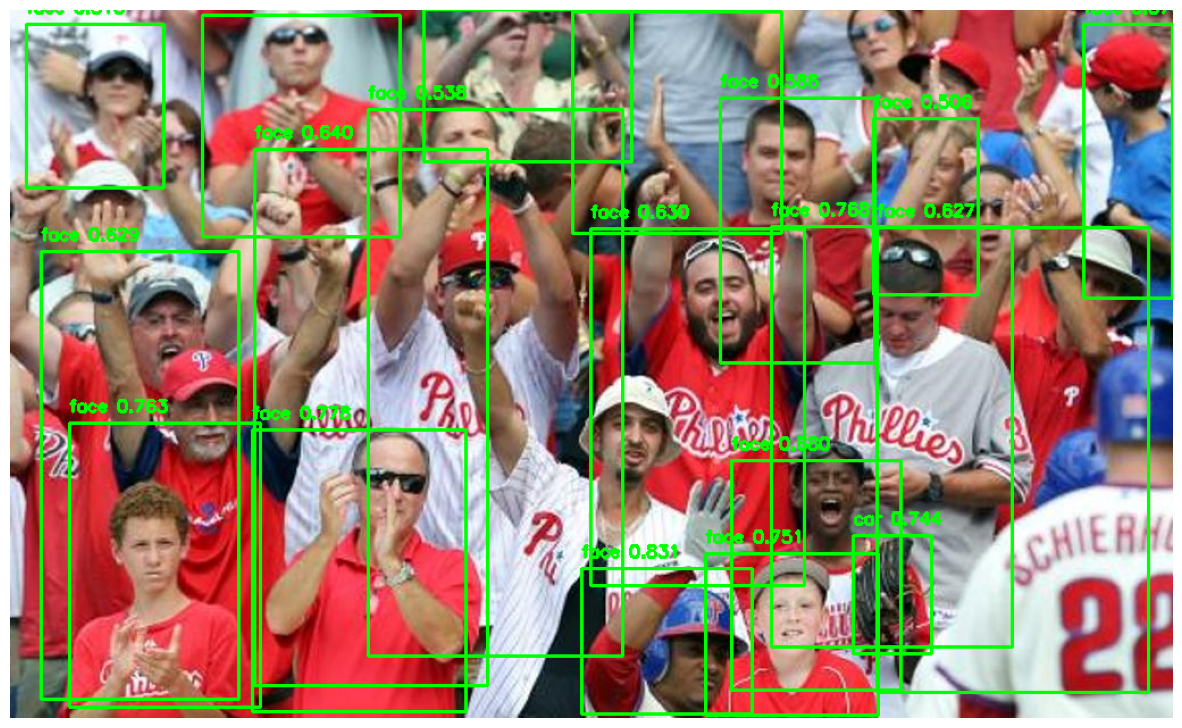

In [11]:
# Visualize detections
img = cv2.imread(target_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box, score, label in zip(outputs[0]["boxes"], outputs[0]["scores"], outputs[0]["labels"]):
    if score < thresh:
        break

    color = (0, 255, 0)  # Green color for bounding box
    box = box.cpu().numpy().astype(int)
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
    label_str = "{} {:.3f}".format(labels_to_names[int(label)], score)
    cv2.putText(img, label_str, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(img)
plt.show()

In [46]:
labels_to_names

{0: 'background', 1: 'face', 40: 'car'}